In [1]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
from earlystop import EarlyStopper
from lstm_models import AirModel, StackLSTM, AirModel_DropOut


#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils


np.random.seed(seed=77)
torch.manual_seed(77)

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file7_080124.mat"
cutoff = [8/1000, 11/1000]

mat = ds.MatFileToDataFrame(fpath, fname)

df_ = mat.get_dataframe(cutoff)

x = dc.CaractDefect(df_)
taus = x.get_tau()[1]

hilbert, _ = x.get_hilbert()

df = pd.merge(df_, hilbert, on = 'Hilbert Transform', how = 'outer')

df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.134180,0.023473,0.002203,0.002203-0.001490j,0.002659,-0.594742,-0.051439
1,0.135824,0.025117,0.002051,0.002051+0.000170j,0.002058,0.082612,-0.020024
2,0.136482,0.025775,0.001900,0.001900+0.000303j,0.001924,0.158163,0.009547
3,0.137797,0.027090,0.001749,0.001749+0.000903j,0.001969,0.476669,0.035605
4,0.137797,0.027090,0.001599,0.001599+0.000993j,0.001882,0.555726,0.056848


### **data**

In [3]:
amplitudes = df['Amplitude'][300:30000].values
train, val = utils.split_data(amplitudes)
x_train, y_train = utils.create_dataset(train, 100)
x_val, y_val = utils.create_dataset(val, 100)
train_loader = utils.create_loader(x_train, y_train, 32)
val_loader = utils.create_loader(x_val, y_val, 32)

print(x_train.shape, y_train.shape ,x_val.shape, y_val.shape)

torch.Size([23660, 100, 1]) torch.Size([23660, 100, 1]) torch.Size([5840, 100, 1]) torch.Size([5840, 100, 1])


## **model**


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 1.081986709905507e-05, Test Loss: 3.62012288367305e-07
Epoch: 0, Loss: 8.815846399556904e-07


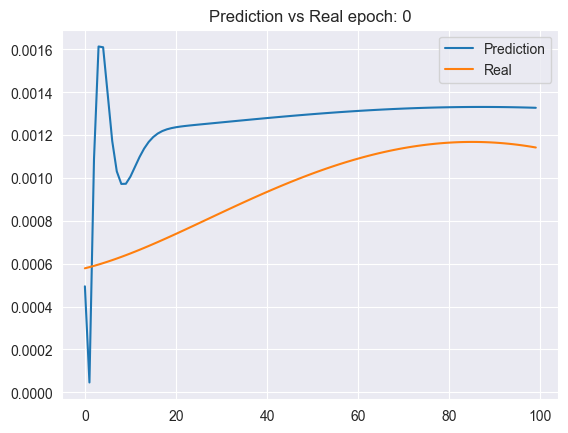

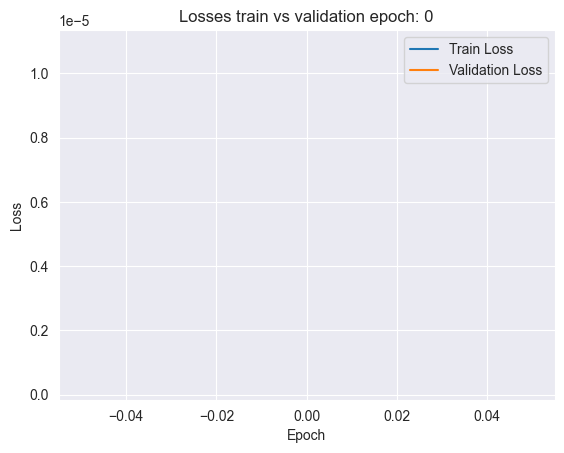

 10%|█         | 10/100 [03:09<28:18, 18.87s/it]

Epoch: 10, Train Loss: 2.135307097085705e-08, Test Loss: 4.598087693232317e-09
Epoch: 10, Loss: 1.2949359806668781e-08


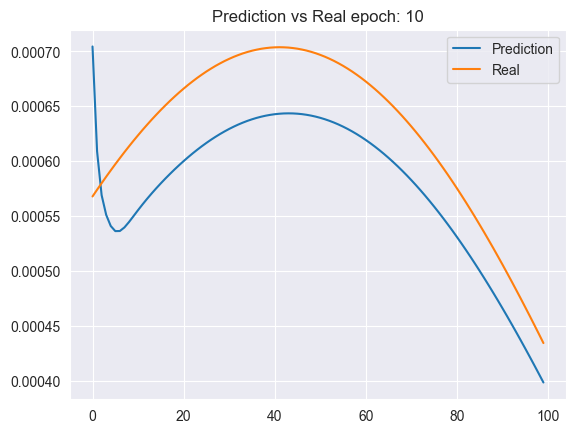

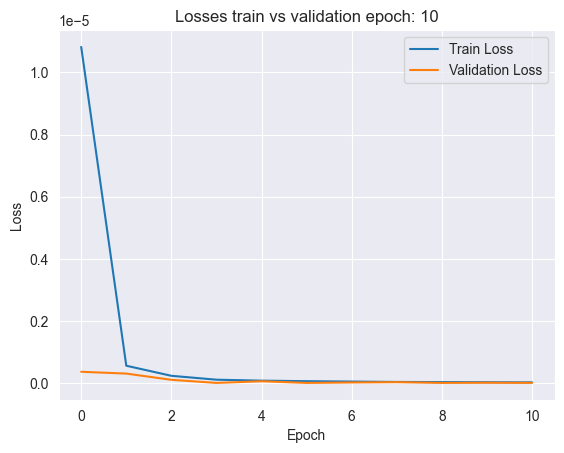

 20%|██        | 20/100 [06:22<25:24, 19.05s/it]

Epoch: 20, Train Loss: 9.397167347872373e-09, Test Loss: 8.045541898157431e-10
Epoch: 20, Loss: 1.990213993607881e-09


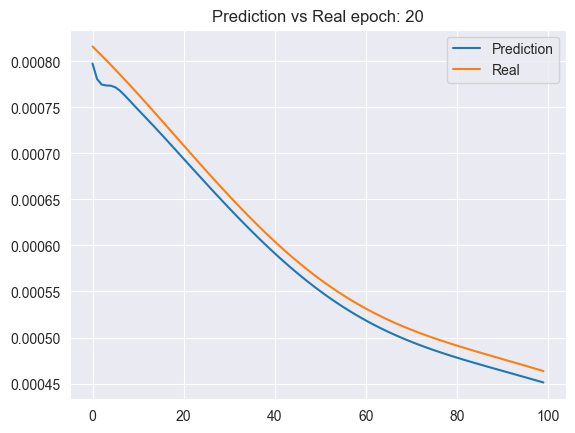

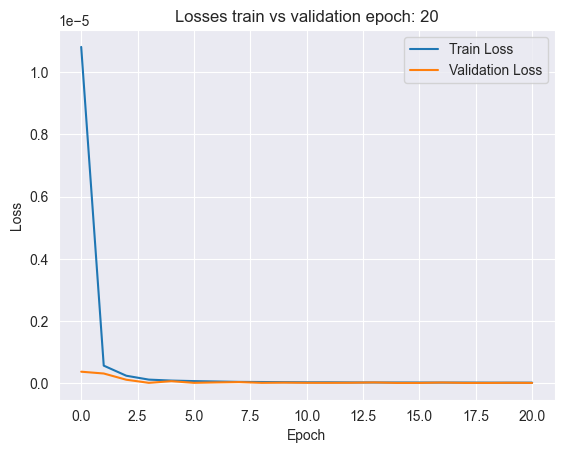

 30%|███       | 30/100 [09:31<22:02, 18.89s/it]

Epoch: 30, Train Loss: 7.226130342820438e-09, Test Loss: 1.5320496886914337e-09
Epoch: 30, Loss: 5.197770214238062e-09


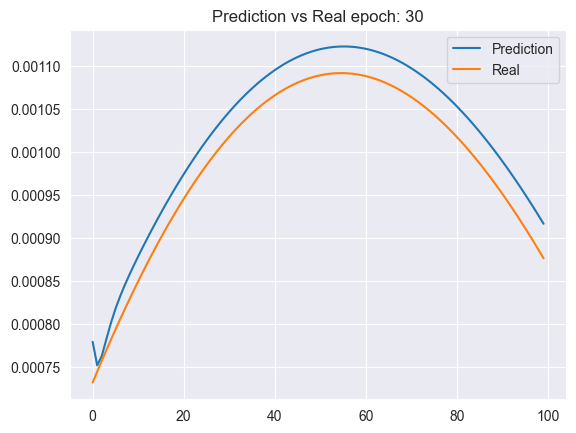

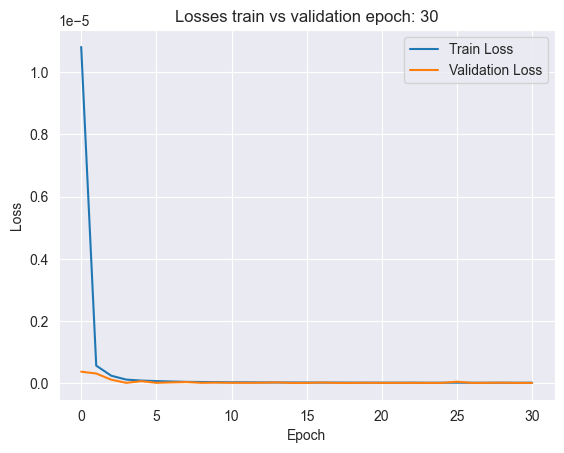

 40%|████      | 40/100 [12:42<18:59, 19.00s/it]

Epoch: 40, Train Loss: 6.269013059043524e-09, Test Loss: 8.510368758462874e-08
Epoch: 40, Loss: 5.0521421712801384e-08


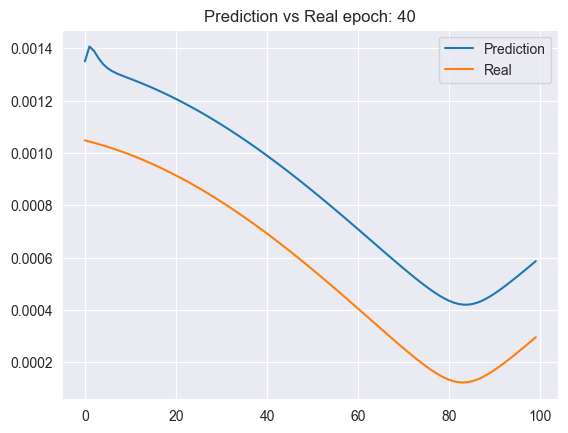

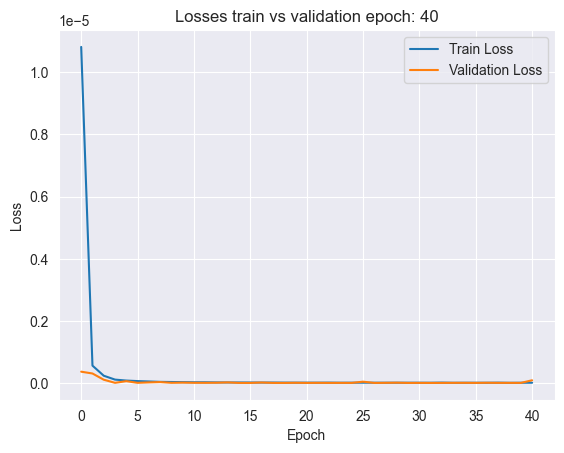

 50%|█████     | 50/100 [15:54<15:57, 19.16s/it]

Epoch: 50, Train Loss: 1.1389609093922233e-08, Test Loss: 1.1094279799635998e-09
Epoch: 50, Loss: 4.343354564895208e-09


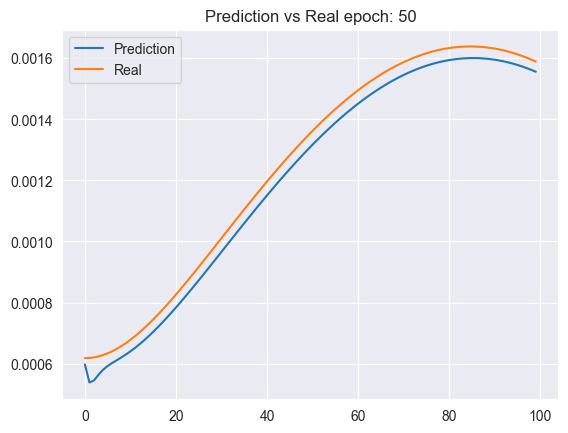

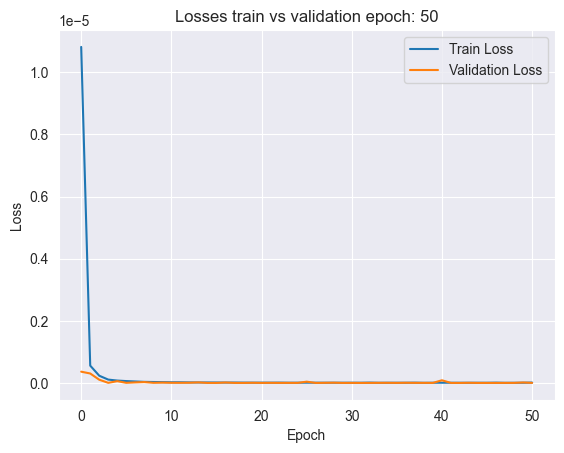

 60%|██████    | 60/100 [22:12<25:37, 38.44s/it]

Epoch: 60, Train Loss: 5.238793656688919e-09, Test Loss: 2.742291395784573e-09
Epoch: 60, Loss: 4.028222644336665e-09


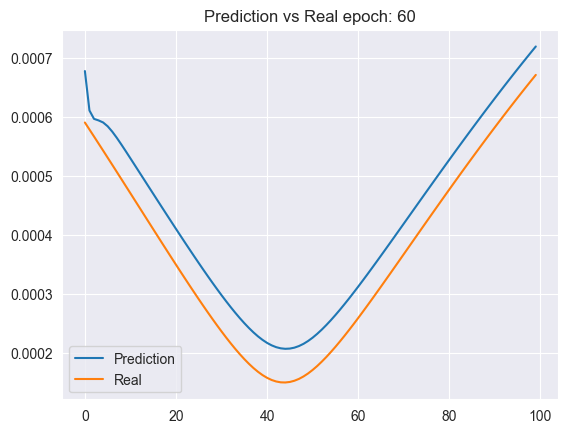

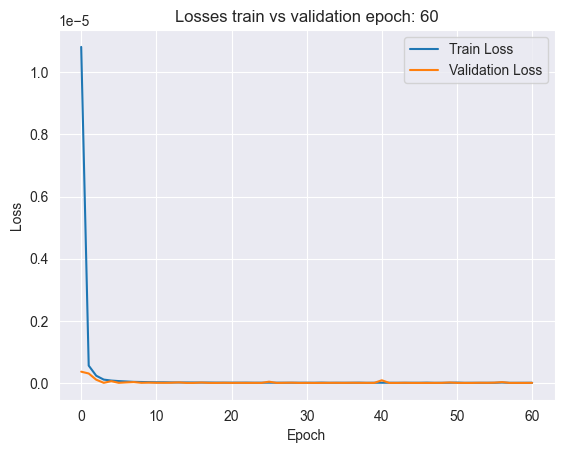

 70%|███████   | 70/100 [25:28<09:59, 19.99s/it]

Epoch: 70, Train Loss: 1.2405934509189868e-08, Test Loss: 1.9966874260537048e-10
Epoch: 70, Loss: 2.024527212540761e-09


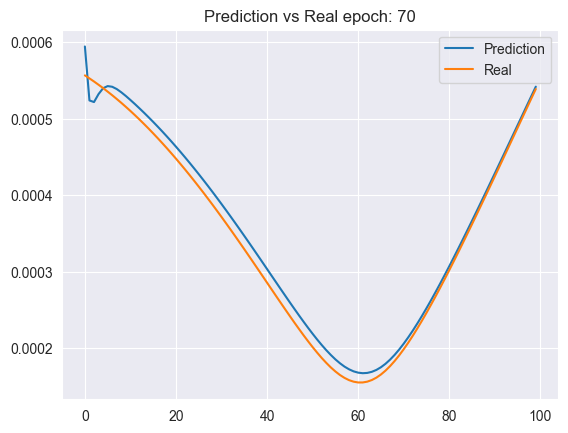

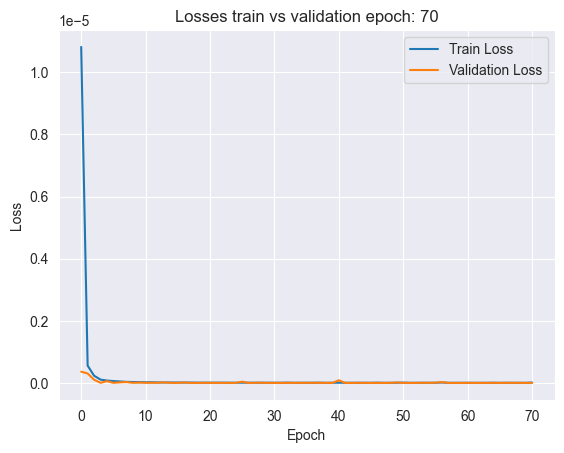

 80%|████████  | 80/100 [28:46<06:32, 19.61s/it]

Epoch: 80, Train Loss: 4.592121254125318e-09, Test Loss: 7.190029242904058e-10
Epoch: 80, Loss: 1.0516649773251174e-09


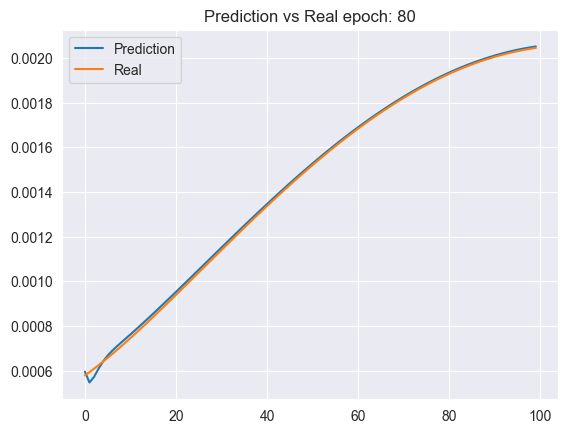

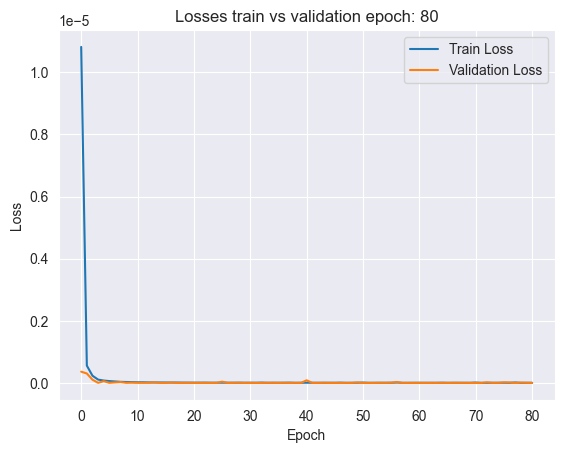

 90%|█████████ | 90/100 [31:59<03:12, 19.26s/it]

Epoch: 90, Train Loss: 4.756533190968008e-09, Test Loss: 2.9745128970722654e-09
Epoch: 90, Loss: 3.34415894975848e-09


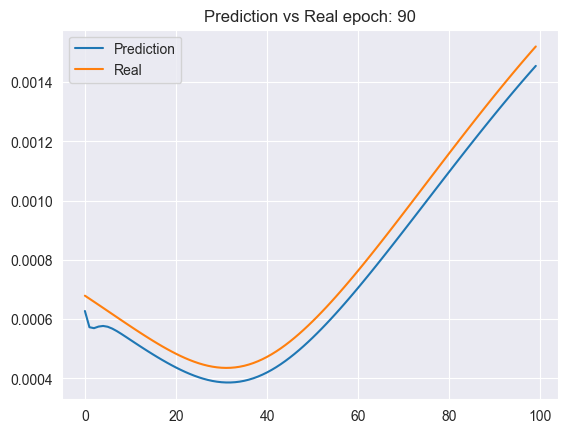

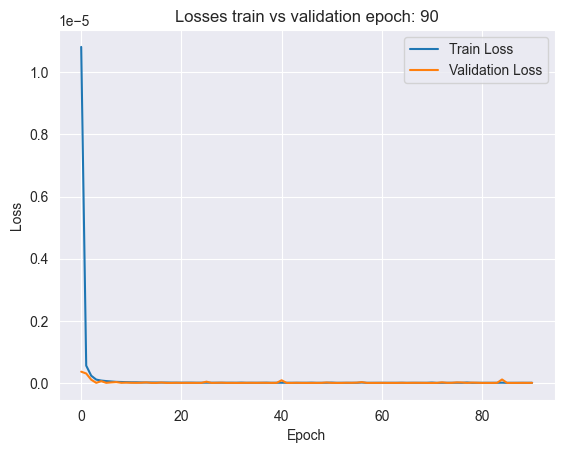

100%|██████████| 100/100 [35:15<00:00, 21.15s/it]


In [4]:
model = AirModel_DropOut()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
n_epochs = 100
ncheckpoint = 10

m, av_train, av_val = utils.train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs, ncheckpoint)

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(av_train[5:])), y=av_train[5:], mode='lines', name='av_train'))
fig.add_trace(go.Scatter(x=np.arange(len(av_val[5:])), y=av_val[5:], mode='lines', name='av_val'))
fig.show()


In [11]:
np.argmin(av_train), np.argmin(av_val)

(71, 97)

## **testing**

In [10]:
fname = "file1_050124.mat"
cutoff = [8/1000, 11/1000]

mat = ds.MatFileToDataFrame(fpath, fname)

df_ = mat.get_dataframe(cutoff)

x = dc.CaractDefect(df_)
taus = x.get_tau()[1]

hilbert, _ = x.get_hilbert()

df = pd.merge(df_, hilbert, on = 'Hilbert Transform', how = 'outer')

df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,2.256644,0.049758,0.007786,0.007786-0.004629j,0.009058,-0.536394,-0.056599
1,2.258288,0.051402,0.007361,0.007361+0.000726j,0.007397,0.098350,-0.028915
2,2.260261,0.053375,0.006933,0.006933+0.001102j,0.007020,0.157607,-0.002832
3,2.260918,0.054033,0.006502,0.006502+0.003041j,0.007178,0.437517,0.020193
4,2.262233,0.055348,0.006068,0.006068+0.003316j,0.006915,0.500092,0.039028


In [12]:
amplitudes = df['Amplitude'][300:30000].values

train, val = utils.split_data(amplitudes)
val, test = utils.split_data(val, 0.5)

x_train, y_train = utils.create_dataset(train, 100)
x_val, y_val = utils.create_dataset(val, 100)
x_test, y_test = utils.create_dataset(test, 100)

train_loader = utils.create_loader(x_train, y_train, 32)
val_loader = utils.create_loader(x_val, y_val, 32)
test_loader = utils.create_loader(x_test, y_test, 32)

print(train_loader.dataset.tensors[0].shape, val_loader.dataset.tensors[0].shape, test_loader.dataset.tensors[0].shape)

torch.Size([23660, 100, 1]) torch.Size([2870, 100, 1]) torch.Size([2870, 100, 1])


In [14]:
model_trained = AirModel_DropOut()
optimizer_trained = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [15]:
#cargo modelo
utils.resume(model_trained, optimizer_trained, 'checkpoint_80.pth')

In [16]:
x = utils.predictions(model_trained, val_loader)

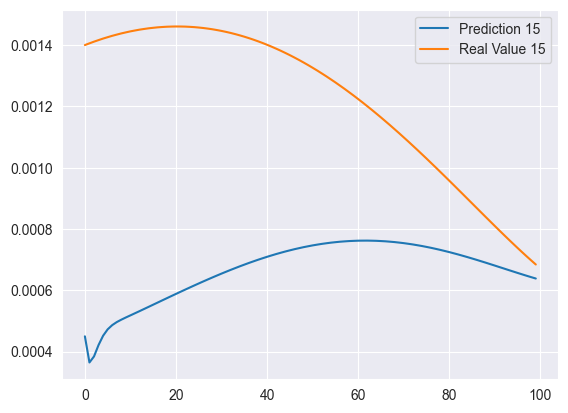

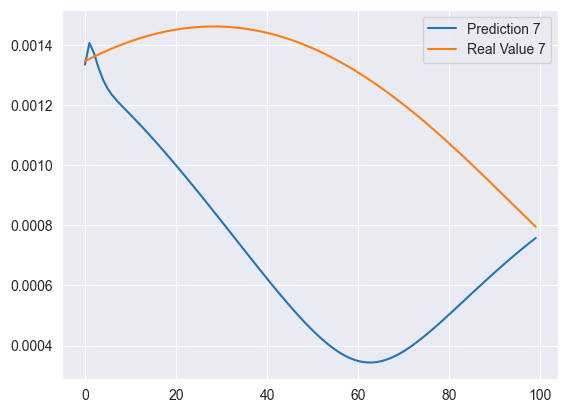

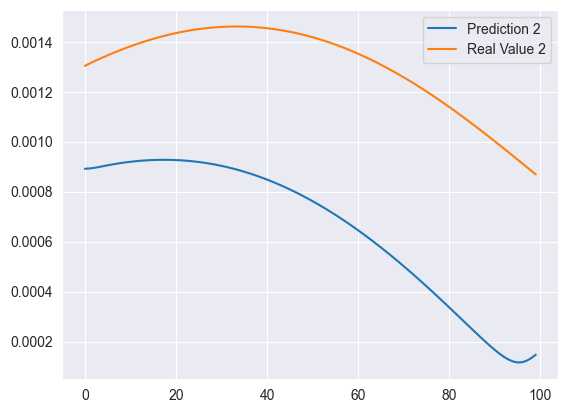

In [18]:
#x = utils.predictions(model_trained, val_loader) 
#Select 3 random indices
random_indices = np.random.choice(len(x), size=3, replace=False)

# Plot the selected predictions and real values
for i in random_indices:
    plt.figure()  # Create a new figure for each iteration
    plt.plot(np.arange(len(x[i])), x[i], label=f'Prediction {i}')
    plt.plot(np.arange(len(y_test[i])), y_test[i], label=f'Real Value {i}')
    plt.legend()
    plt.show()


## **second training**



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 1.4082669473501507e-09, Test Loss: 6.634758427844407e-10
Epoch: 0, Loss: 1.2391564441216474e-09


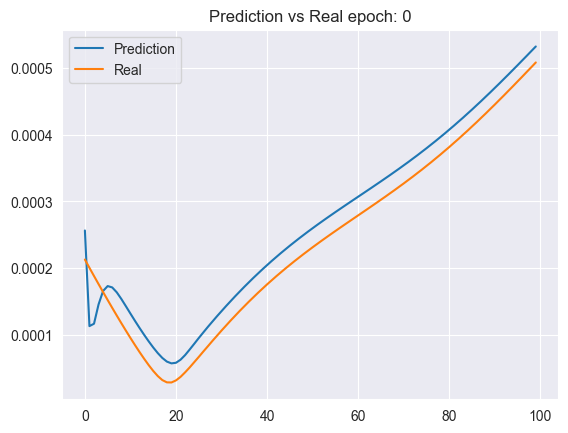

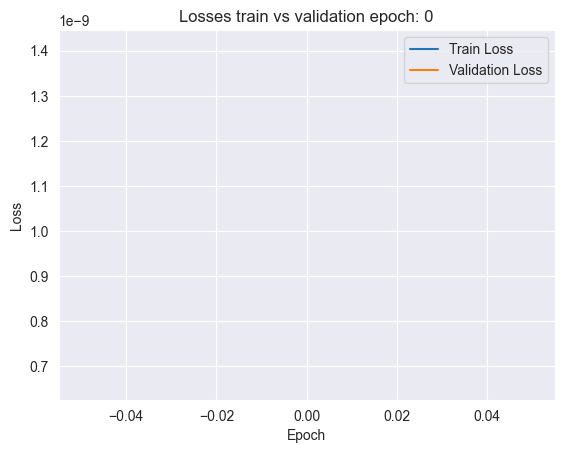

 10%|█         | 10/100 [03:02<26:51, 17.91s/it]

Epoch: 10, Train Loss: 1.4066535238412415e-09, Test Loss: 6.6298027376652e-10
Epoch: 10, Loss: 1.0418790274968615e-09


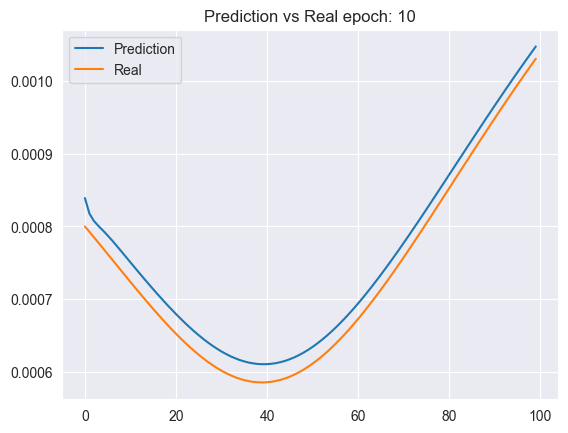

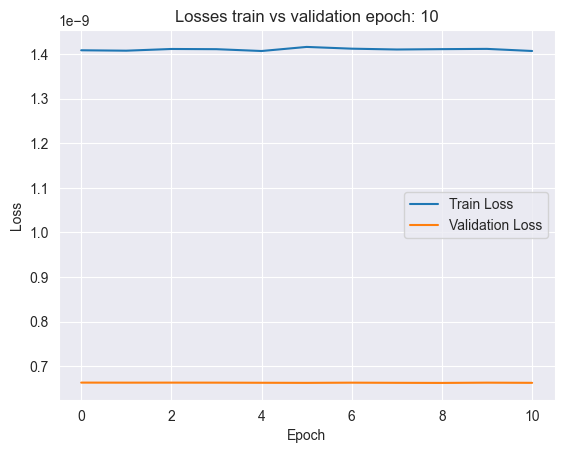

 20%|██        | 20/100 [06:03<24:12, 18.16s/it]

Epoch: 20, Train Loss: 1.4101853113163294e-09, Test Loss: 6.631606177778496e-10
Epoch: 20, Loss: 1.2032795870808854e-09


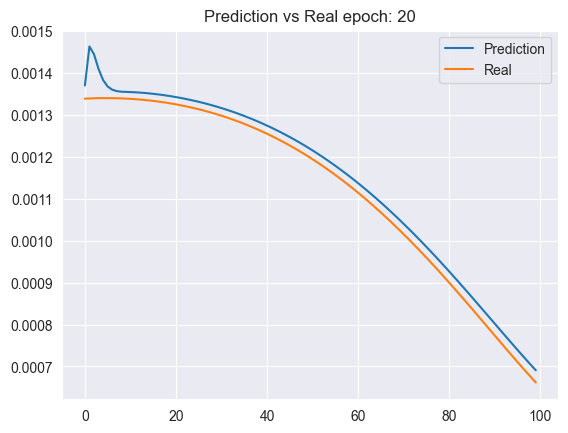

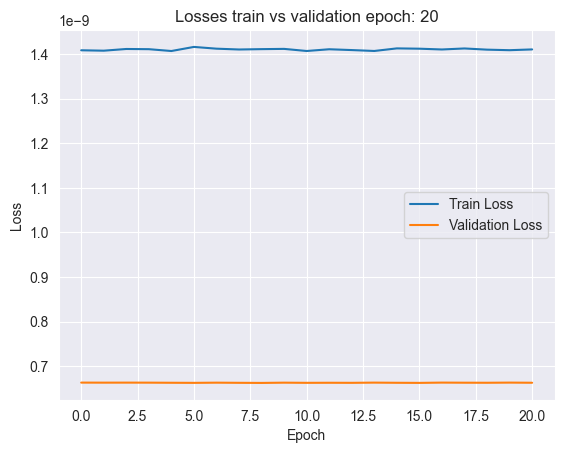

 30%|███       | 30/100 [09:02<20:55, 17.93s/it]

Epoch: 30, Train Loss: 1.4104520736042643e-09, Test Loss: 6.631355532594875e-10
Epoch: 30, Loss: 1.253369852349806e-09


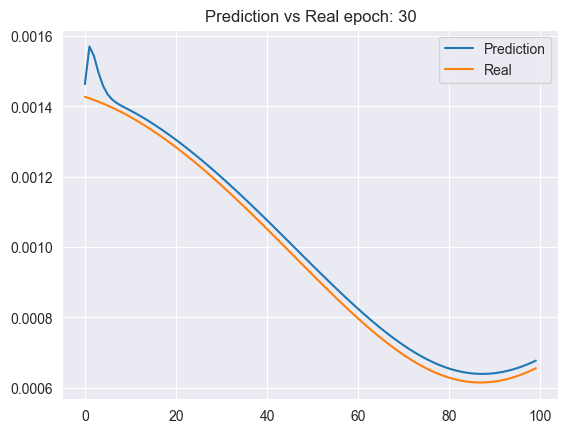

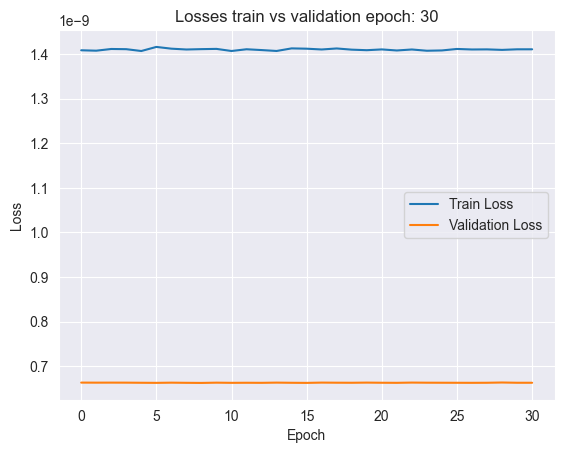

 40%|████      | 40/100 [12:01<17:48, 17.81s/it]

Epoch: 40, Train Loss: 1.4068934871457239e-09, Test Loss: 6.631626340662204e-10
Epoch: 40, Loss: 9.89627491065903e-10


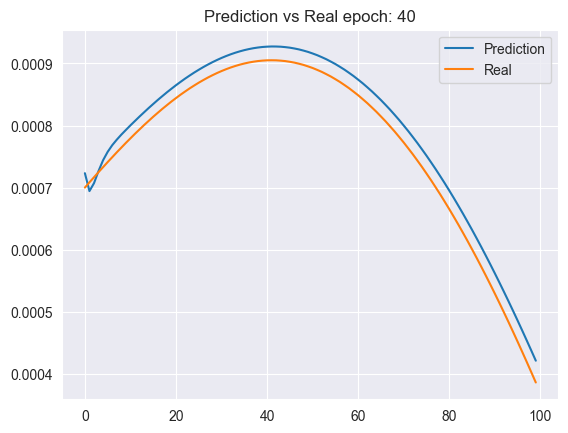

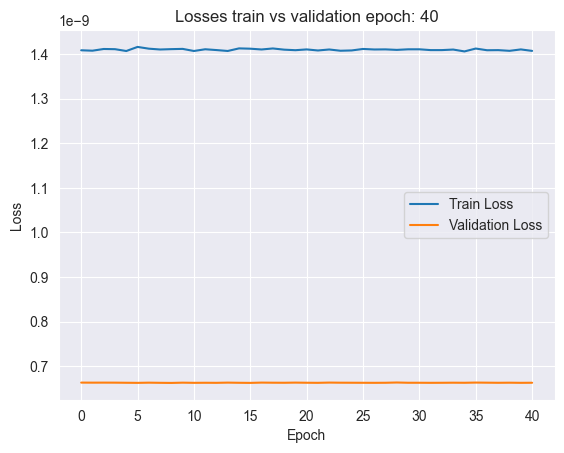

 50%|█████     | 50/100 [14:57<14:36, 17.53s/it]

Epoch: 50, Train Loss: 1.4087430603430254e-09, Test Loss: 6.633006619269664e-10
Epoch: 50, Loss: 9.518843491207463e-10


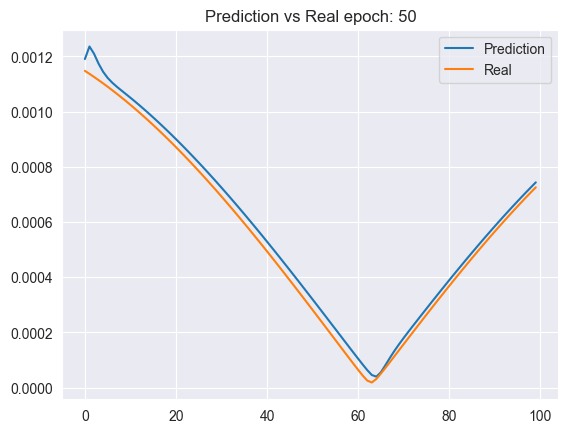

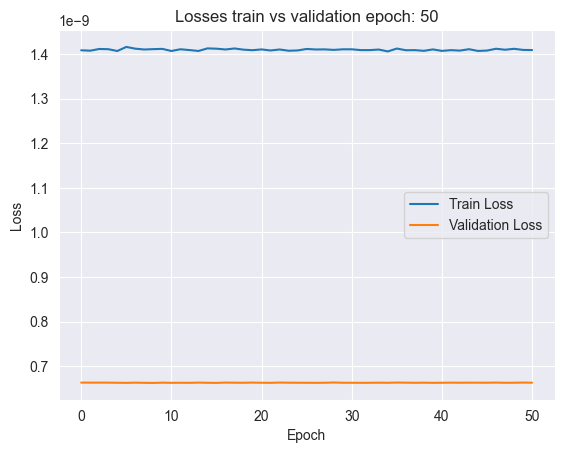

 60%|██████    | 60/100 [17:59<12:03, 18.09s/it]

Epoch: 60, Train Loss: 1.4128142505748081e-09, Test Loss: 6.631262643935148e-10
Epoch: 60, Loss: 1.3961405365137125e-09


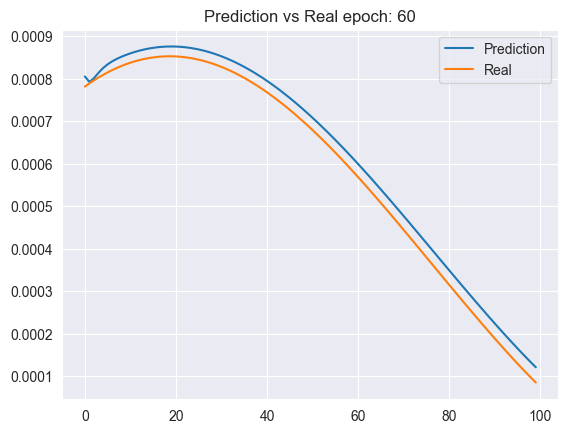

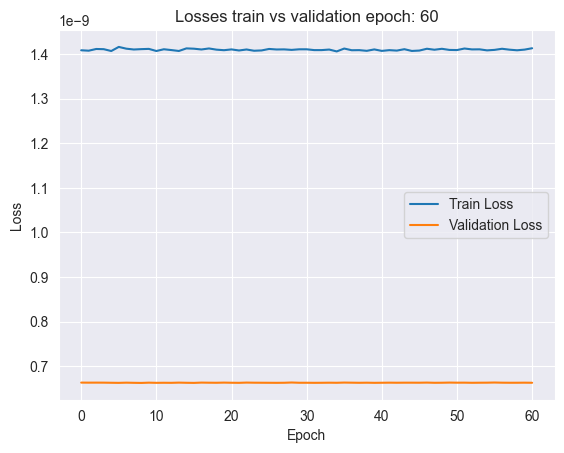

 70%|███████   | 70/100 [21:03<09:10, 18.35s/it]

Epoch: 70, Train Loss: 1.4058937262110242e-09, Test Loss: 6.632893481375549e-10
Epoch: 70, Loss: 1.2423719830678692e-09


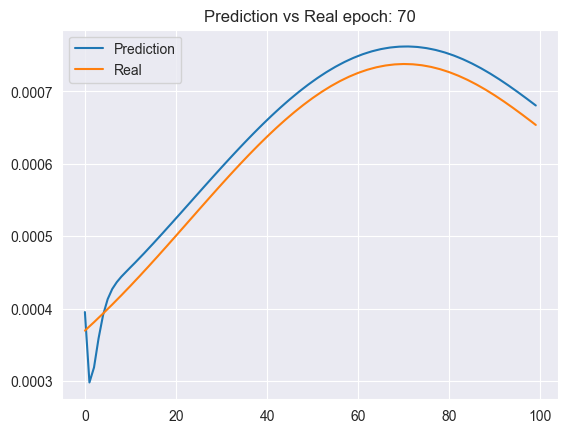

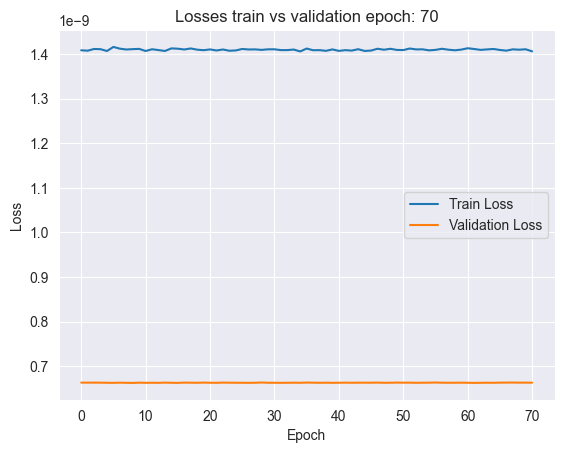

 80%|████████  | 80/100 [23:59<05:50, 17.52s/it]

Epoch: 80, Train Loss: 1.4109803057169698e-09, Test Loss: 6.630828343191632e-10
Epoch: 80, Loss: 1.4978686069255787e-09


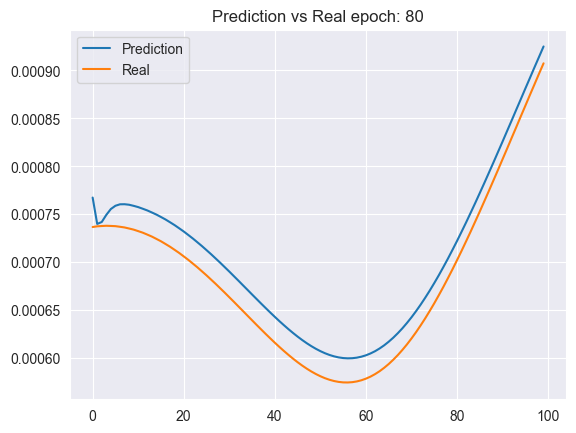

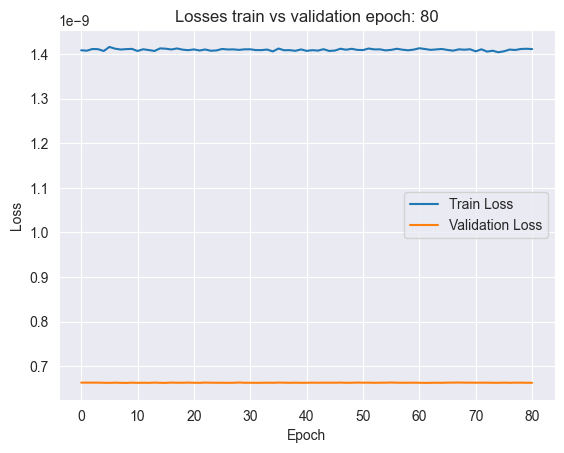

 90%|█████████ | 90/100 [26:57<02:57, 17.78s/it]

Epoch: 90, Train Loss: 1.4089072089176381e-09, Test Loss: 6.631605018212225e-10
Epoch: 90, Loss: 1.168911967219799e-09


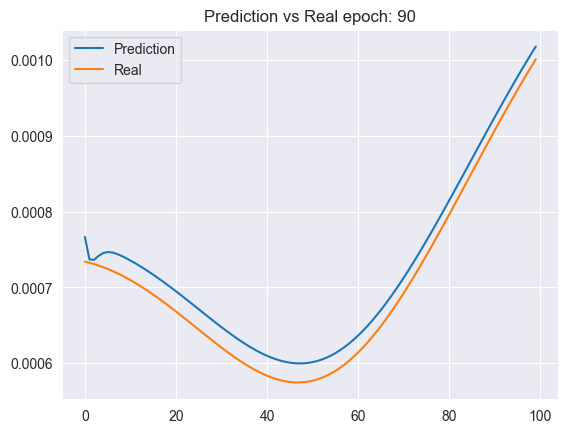

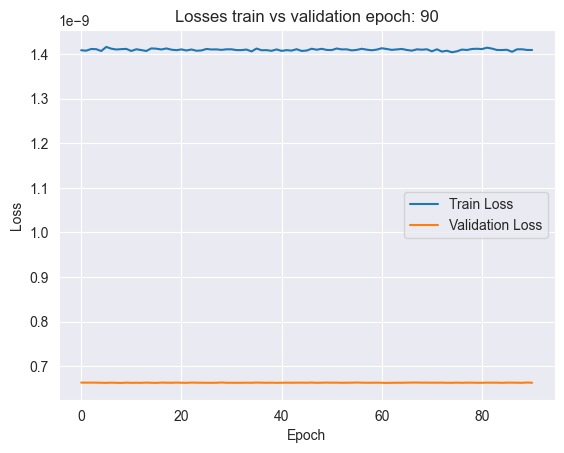

100%|██████████| 100/100 [29:56<00:00, 17.97s/it]


In [19]:
n_epochs = 100
ncheckpoint = 10

m2, av_train2, av_val2 = utils.train_model(model_trained, optimizer_trained, criterion, train_loader, val_loader, n_epochs, ncheckpoint)

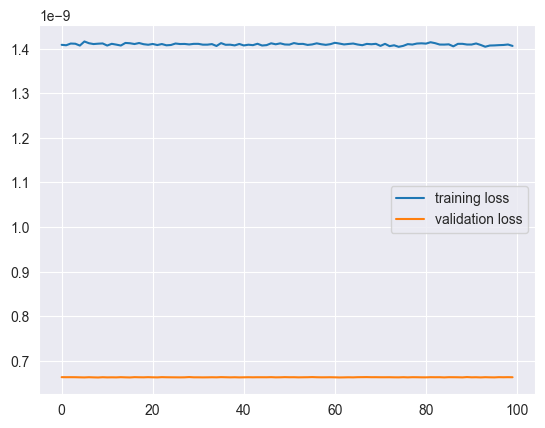

In [22]:
plt.plot(av_train2, label='training loss')
plt.plot(av_val2, label='validation loss')
plt.legend()
plt.show()

## **load and test model**

In [23]:
model_trained2 = AirModel_DropOut()
optimizer_trained2 = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

#cargo modelo
utils.resume(model_trained2, optimizer_trained2, 'checkpoint_60.pth')

In [24]:
x = utils.predictions(model_trained2, test_loader)

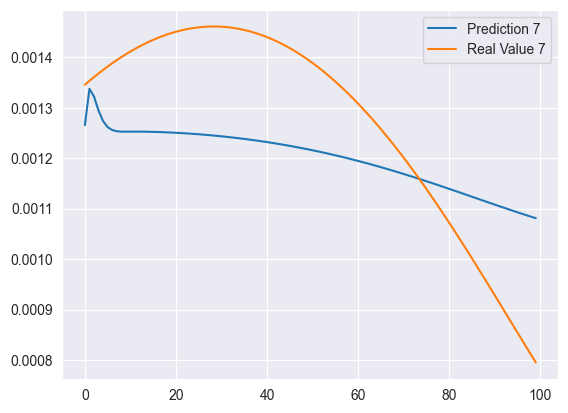

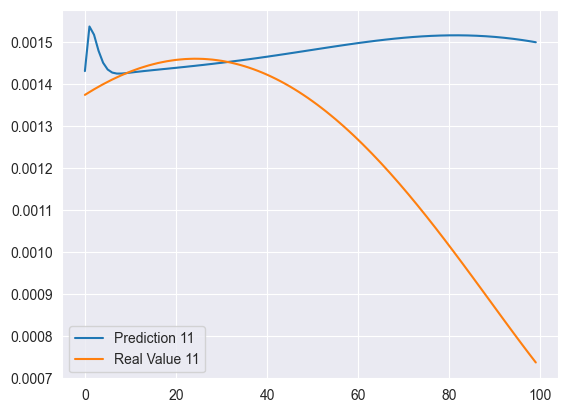

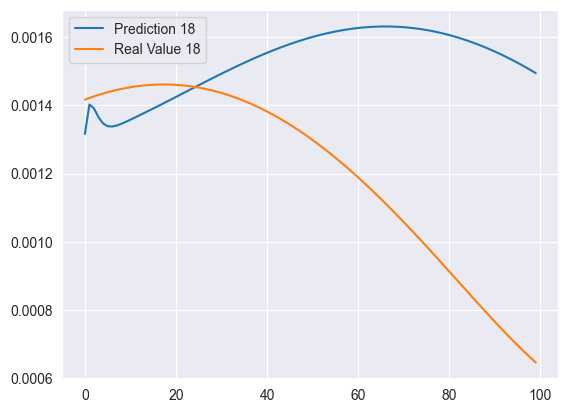

In [25]:
#Select 3 random indices
random_indices = np.random.choice(len(x), size=3, replace=False)

# Plot the selected predictions and real values
for i in random_indices:
    plt.figure()  # Create a new figure for each iteration
    plt.plot(np.arange(len(x[i])), x[i], label=f'Prediction {i}')
    plt.plot(np.arange(len(y_test[i])), y_test[i], label=f'Real Value {i}')
    plt.legend()
    plt.show()